In [49]:
%load_ext autoreload
%autoreload 2
from src.data.data_loader import TwitterDataset
import pandas as pd
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence, pack_padded_sequence, pad_sequence, PackedSequence
from torch.nn import LSTM, Embedding, Module, Linear, ReLU, Sequential
from torch.utils.data import DataLoader, Sampler, RandomSampler, BatchSampler, SequentialSampler

import torch
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
data = pd.read_pickle('../../data/interim/hydrated/200316.pkl')

class PredictiveDataset(TwitterDataset):
    
        
    def __getitem__(self, indices):
        
        values =  sorted([self.encoded[i] for i in indices], key=lambda x: -len(x))
        
        inputs =  [value[:-1] for value in values]
        targets = [value[1:] for value in values]
        
        X = pack_sequence(sorted(inputs, key=lambda x: -len(x)))
        y = pack_sequence(sorted(targets, key=lambda x: -len(x)))
        
        return X, y
        
dataset_train = PredictiveDataset(data.iloc[:5000, :].copy())
dataset_validation = PredictiveDataset(data.iloc[5000:7000, :].copy())

num_classes = len(dataset_train.alphabet)

100%|██████████| 2000/2000 [00:00<00:00, 68665.09it/s]


In [3]:
batch_size = 100

def get_loader( dataset, batch_size ):

    sampler = BatchSampler(
        RandomSampler(dataset),
        batch_size=batch_size,
        drop_last=False
    )
    return DataLoader(
        dataset,
        batch_size=None,
        sampler=sampler,
    )

train_loader = get_loader( dataset_train, batch_size )

In [4]:
def simple_elementwise_apply(fn, packed_sequence):
    """applies a pointwise function fn to each element in packed_sequence"""
    return PackedSequence(fn(packed_sequence.data), packed_sequence.batch_sizes)

class OneHotPacked(Module):

    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, x):
        return simple_elementwise_apply(F.one_hot, x)

class EmbeddingPacked(Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.embedding = Embedding(**kwargs)

    def forward(self, x):
        return simple_elementwise_apply(self.embedding, x)

one_hot = OneHotPacked(num_classes=num_classes)

embedding = EmbeddingPacked(
    num_embeddings = num_classes,
    embedding_dim = 10,
)

In [43]:
class SimpleRNN(Module):
    
    def __init__(self):
        
        super().__init__()
        
#         self.one_hot = OneHotPacked(num_classes=num_classes)
        self.embedding = EmbeddingPacked(
            num_embeddings = num_classes,
            embedding_dim = 10,
        )
        
        self.lstm = LSTM(
            input_size = 10,
            hidden_size = 50,
            num_layers = 1,
            bidirectional = False,
        )
        
        self.dense = Sequential(
            Linear(
                in_features = 50,
                out_features = 100
            ),
            ReLU(inplace = True),
            Linear(
                in_features = 100,
                out_features = num_classes
            ),
        )
            
    def forward(self, x):
        
        # Define packing here?
        x = self.embedding(x)
        
        packed_output, (ht, ct) = self.lstm(x)
        
        return simple_elementwise_apply(self.dense, packed_output)
        


In [48]:
# Initialize a new network
net = SimpleRNN()

if cuda:
    net = net.cuda()
    
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if cuda:
        return x.cuda()
    return x

NameError: name 'cuda' is not defined

In [46]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from tqdm import tqdm


# Hyper-parameters
num_epochs = 10


# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = CrossEntropyLoss()
optimizer = SGD(net.parameters(), lr=0.001, momentum=0.9)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.train()
    
    # For each sentence in training set
    for X, y in tqdm(train_loader):
        
        
        X = get_variable(X)
        y = get_variable(y)
        
        # Forward pass
        # YOUR CODE HERE!
        packed_outputs = net(X)
        
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(packed_outputs.data, y.data)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(dataset_train))

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


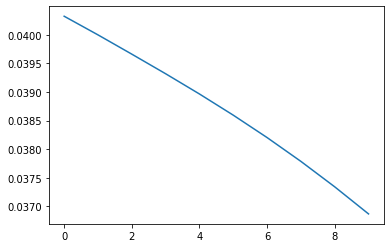

In [47]:
import seaborn as sns
sns.lineplot(x=range(len(training_loss)), y=training_loss);

/usr/local/Caskroom/miniconda/base/envs/deep-learning-vlae/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

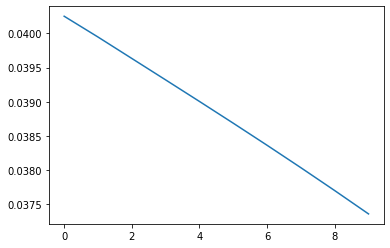

In [30]:
sns.lineplot()

In [20]:
dir(sns)

['FacetGrid',
 'JointGrid',
 'PairGrid',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_core',
 '_decorators',
 '_docstrings',
 '_orig_rc_params',
 '_statistics',
 'algorithms',
 'axes_style',
 'axisgrid',
 'barplot',
 'blend_palette',
 'boxenplot',
 'boxplot',
 'categorical',
 'catplot',
 'choose_colorbrewer_palette',
 'choose_cubehelix_palette',
 'choose_dark_palette',
 'choose_diverging_palette',
 'choose_light_palette',
 'clustermap',
 'cm',
 'color_palette',
 'colors',
 'countplot',
 'crayon_palette',
 'crayons',
 'cubehelix_palette',
 'dark_palette',
 'desaturate',
 'despine',
 'displot',
 'distplot',
 'distributions',
 'diverging_palette',
 'dogplot',
 'ecdfplot',
 'external',
 'factorplot',
 'get_data_home',
 'get_dataset_names',
 'heatmap',
 'histplot',
 'hls_palette',
 'husl_palette',
 'jointplot',
 'kdeplot',
 'light_palette',
 'lineplot',
 'lmplot',
 'load_dataset',
 'matrix',